In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [2]:
def plot_graph(history,metric):
  plt.plot(history[metric], label = metric)
  plt.plot(history[f"val_{metric}"], label = f"val_{metric}")
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info = True,
                          as_supervised = True)
test_dataset = dataset['test']
# create train and validation splits by splitting training set into half
train_dataset, validation_dataset = tfds.load('imdb_reviews/subwords8k', split = ['train[50%:]','train[-50%:]'])

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3A6797/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3A6797/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3A6797/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
# preprocess the data so it'll become a pair of tuples rather than dictionaries
train_ds = train_dataset.map(lambda x: (x['text'],x['label']))
val_ds = validation_dataset.map(lambda x: (x['text'],x['label']))

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [7]:
sample_string = 'Hello Tensorflow'
encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 2934]
The original string: "Hello Tensorflow"


In [8]:
for index in encoded_string:
  print('{} ---> {}'.format(index, encoder.decode([index])))

4025 ---> Hell
222 ---> o 
6307 ---> Ten
2327 ---> sor
2934 ---> flow


In [9]:
# prepare the data for training
# create batches of encoded strings
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.padded_batch(BATCH_SIZE)
val_ds = val_ds.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [11]:
train_ds = train_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)
val_ds = train_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)
test_ds = train_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)

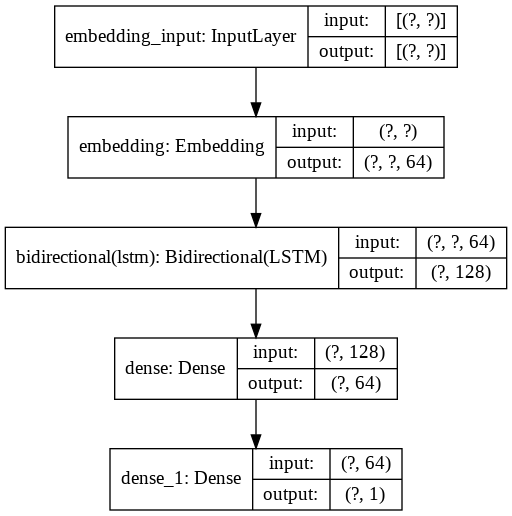

In [12]:
# create the model with Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, 64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dense(1)
])
tf.keras.utils.plot_model(model, show_shapes = True)

In [13]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics = ['accuracy'])

In [14]:
history = model.fit(train_ds, 
                    validation_data = val_ds,
                    epochs = 10,
                    validation_steps = 30)

Epoch 1/10
196/196 [==============================] - 65s 331ms/step - loss: 0.6010 - accuracy: 0.6277 - val_loss: 0.4105 - val_accuracy: 0.8234
Epoch 2/10
196/196 [==============================] - 63s 321ms/step - loss: 0.3547 - accuracy: 0.8470 - val_loss: 0.2847 - val_accuracy: 0.8896
Epoch 3/10
196/196 [==============================] - 63s 322ms/step - loss: 0.2962 - accuracy: 0.8741 - val_loss: 0.2317 - val_accuracy: 0.9062
Epoch 4/10
196/196 [==============================] - 63s 321ms/step - loss: 0.2156 - accuracy: 0.9134 - val_loss: 0.2046 - val_accuracy: 0.9130
Epoch 5/10
196/196 [==============================] - 63s 320ms/step - loss: 0.1859 - accuracy: 0.9302 - val_loss: 0.5226 - val_accuracy: 0.8422
Epoch 6/10
196/196 [==============================] - 63s 320ms/step - loss: 0.1836 - accuracy: 0.9336 - val_loss: 0.1064 - val_accuracy: 0.9656
Epoch 7/10
196/196 [==============================] - 63s 320ms/step - loss: 0.0989 - accuracy: 0.9684 - val_loss: 0.0822 - val_ac

In [15]:
model.evaluate(test_ds)

196/196 [==============================] - 23s 116ms/step - loss: 0.0489 - accuracy: 0.9850


[0.04892256483435631, 0.985040009021759]